In [35]:
!pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [36]:
import numpy as np
import mediapipe as mp
import pandas as pd
import scipy.io as sio
from math import cos, sin

from google.colab.patches import cv2_imshow
import os
import sys
from pycocotools.coco import COCO
import urllib
import zipfile
import cv2,glob,random
from sklearn.model_selection import train_test_split ,GridSearchCV
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
np.random.seed(0)
 

In [37]:
DataAlfwURL=' http://www.cbsr.ia.ac.cn/users/xiangyuzhu/projects/3DDFA/Database/AFLW2000-3D.zip'
urllib.request.urlretrieve(DataAlfwURL, filename='AFLW2000-3D.zip')

('AFLW2000-3D.zip', <http.client.HTTPMessage at 0x7f06bd38d130>)

In [38]:
#unzipping the file
with zipfile.ZipFile('AFLW2000-3D.zip','r') as zip:
    zip.extractall()

In [39]:
imagesArr = glob.glob('AFLW2000/*.jpg') #images 
matricesArr=glob.glob('AFLW2000/*.mat') #for labels extraction

print('Images size: ',len(imagesArr))
print('Matrices size: ',len(matricesArr))

Images size:  2000
Matrices size:  2000


In [40]:
print(matricesArr[0])

AFLW2000/image02470.mat


In [41]:
for f in imagesArr:
    image=cv2.imread(f)
    if image.shape !=(450,450,3):
        print(image.shape)
print('image shape: ',image.shape)

image shape:  (450, 450, 3)


In [42]:
for f in imagesArr:
    image=cv2.imread(f)
    faceMat=mp.solutions.face_mesh
    with faceMat.FaceMesh(static_image_mode=True) as faces:
        res = faces.process(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
        if res.multi_face_landmarks != None:
            for face in res.multi_face_landmarks:
                if len(face.landmark)!=468:
                    print(len(face.landmark))
print('ALL imgs has 1 or less humans')

ALL imgs has 1 or less humans


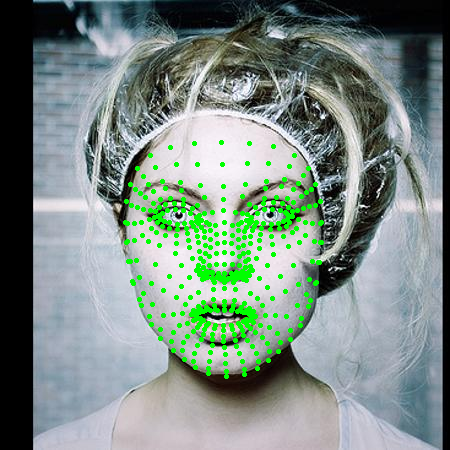

In [43]:
# choosing random image
random_file = 'image00466'

faceModule = mp.solutions.face_mesh
# loading image and its correspinding mat file
with faceModule.FaceMesh(static_image_mode=True) as faces:
    # loading the image
    image = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')
    # processing the face to extract the landmark points (468 point) for each x,y,z
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None: 
      # looping over the faces in the image
      for face in results.multi_face_landmarks:
          for landmark in face.landmark:
              x = landmark.x
              y = landmark.y
              # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
              shape = image.shape 
              relative_x = int(x * shape[1])
              relative_y = int(y * shape[0])
              cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
      cv2_imshow(image)    

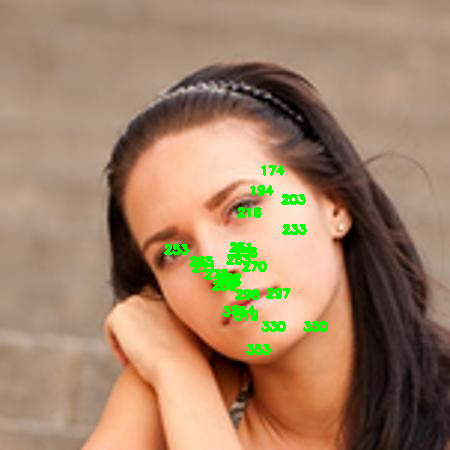

In [93]:
# choosing random image
random_file = 'image00846'
X,Y=[],[]
xPts,yPts=[],[]
faceModule = mp.solutions.face_mesh
# loading image and its correspinding mat file
with faceModule.FaceMesh(static_image_mode=True) as faces:
    # loading the image
    image = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')
    # processing the face to extract the landmark points (468 point) for each x,y,z
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None: 
      # looping over the faces in the image
      i=0
      for face in results.multi_face_landmarks:
          for landmark in face.landmark:
              x = landmark.x
              y = landmark.y
              # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
              shape = image.shape 
              relative_x = int(x * shape[1])
              relative_y = int(y * shape[0])
              X.append(relative_x)
              Y.append(relative_y)
              

              if i%20==0:
                cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
              i+=1
          cv2_imshow(image)  
    X=np.array(X)
    Y=np.array(Y)
    xPts.append(X)
    yPts.append(Y)
       

In [94]:
xPts=np.array(xPts)
yPts=np.array(yPts)
print(xPts.shape)
print(yPts.shape)

(1, 468)
(1, 468)


In [95]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

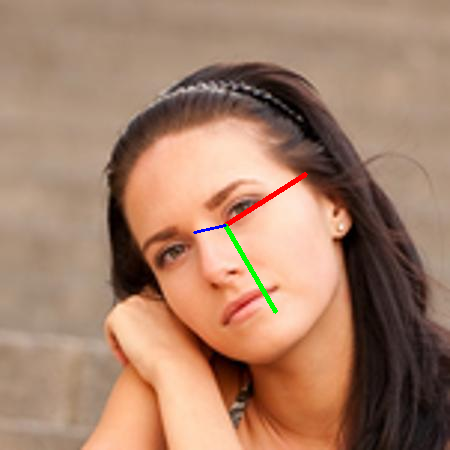

In [96]:
image = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')
# loading the mat file to extract the 3 angels of the face (pitch,yaw,roll)
mat_file = sio.loadmat('/content/AFLW2000/'+random_file+'.mat')
# extracting the labels 3 angels
pose_para = mat_file["Pose_Para"][0][:3]
pitch = pose_para[0]
yaw = pose_para[1]
roll = pose_para[2]
cv2_imshow(draw_axis(image,pitch,yaw,roll))

In [97]:
xPts,yPts=[],[]
validFiles=[]
labels=[]
faceModule = mp.solutions.face_mesh
for f in imagesArr:
   
    with faceModule.FaceMesh(static_image_mode=True) as faces:
        img = cv2.imread(f)
        res=faces.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        if res.multi_face_landmarks != None:
            validFiles.append(f)
            face=res.multi_face_landmarks[0]
            X,Y=[],[]
            for lM in face.landmark:
                x=lM.x
                y=lM.y
                shape = img.shape 
                #relative_x = int(x * shape[1])
                #relative_y = int(y * shape[0])
                X.append(int(x * shape[1]))
                Y.append(int(y * shape[0])) 

            X=np.array(X)
            Y=np.array(Y)
            xPts.append(X)
            yPts.append(Y)
            
            mat_file = sio.loadmat(matricesArr[imagesArr.index(f)])
            pose_para = mat_file["Pose_Para"][0][:3]
            labels.append(pose_para)
xPts=np.array(xPts)
yPts=np.array(yPts)
labels=np.array(labels)
pitches = labels[:,0] 
yaws = labels[:,1]
rolls = labels[:,2]            

In [49]:
print(xPts.shape)
print(yPts.shape)
print(labels.shape)
print(len(validFiles))
print(yaws.shape)


(1853, 468)
(1853, 468)
(1853, 3)
1853
(1853,)


In [50]:
#top of head = 10
#bottom of head = 171
#center=99

x_center = xPts - xPts[:,99].reshape(-1,1)
y_center = yPts - yPts[:,99].reshape(-1,1) 
#normalizing the data 
X_171 = xPts[:,171]
X_10 = xPts[:,10]
Y_171 = yPts[:,171]
Y_10 = yPts[:,10]
# computing the distance
distance = np.linalg.norm(np.array((X_10,Y_10)) - np.array((X_171,Y_171)),axis = 0).reshape(-1,1)
Norm_x = x_center / distance
Norm_y = y_center / distance
final_x = Norm_x
final_y = Norm_y
features = np.hstack([final_x,final_y])

print(final_x.shape)
print(final_y.shape)
print(features.shape)
print(labels.shape)

(1853, 468)
(1853, 468)
(1853, 936)
(1853, 3)


In [51]:
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

pitch_model = XGBRegressor(random_state=0,verbosity = 0)

yaw_model = XGBRegressor(random_state=0,verbosity = 0)
roll_model = XGBRegressor(random_state=0,verbosity = 0)
pitch_crossval = cross_val_score(pitch_model,features,pitches,scoring="neg_mean_absolute_error")
yaw_crossval = cross_val_score(yaw_model,features,yaws,scoring="neg_mean_absolute_error")
roll_crossval = cross_val_score(roll_model,features,rolls,scoring="neg_mean_absolute_error") 

# print(pitch_crossval)
# print(yaw_crossval)
# print(roll_crossval)
# # computing the mean
# print(pitch_crossval.mean())
# print(yaw_crossval.mean())
# print(roll_crossval.mean())



In [52]:
print(pitch_crossval)
print(pitch_crossval.mean())

print(yaw_crossval)
print(yaw_crossval.mean())

print(roll_crossval)
print(roll_crossval.mean())

[-0.34021383 -0.32568263 -0.29337236 -0.2765544  -0.33195291]
-0.3135552248847137
[-0.50744937 -0.5499079  -0.4831492  -0.50170963 -0.50699284]
-0.509841788011392
[-0.37640265 -0.35036249 -0.34713546 -0.28487626 -0.3779571 ]
-0.3473467933314989


In [53]:
X_train,X_val,y_train,y_val,file_train,file_test = train_test_split(features,labels,validFiles,test_size = 0.2,random_state = 20)
y_train_pitch = y_train[:,0]
y_train_yaw = y_train[:,1]
y_train_roll = y_train[:,2]
y_val_pitch = y_val[:,0]
y_val_yaw = y_val[:,1]
y_val_roll = y_val[:,2]

In [54]:
xg_param = {'n_estimators': np.arange(5,9,2),'max_depth': np.arange(1,7,2),'learning_rate': np.arange(0.4,0.8,0.2)}
m_xgb_pitch = XGBRegressor(random_state=0,verbosity=0)
m_gs_xgb_pitch = GridSearchCV(m_xgb_pitch,xg_param)
m_gs_xgb_pitch.fit(X_train,y_train_pitch)
m_gs_xgb_pitch_be = m_gs_xgb_pitch.best_estimator_
y_xgb_train_pitch = m_gs_xgb_pitch_be.predict(X_train)
y_xgb_pred_pitch = m_gs_xgb_pitch_be.predict(X_val)

print(f"XGB Best Estimator of Pitch angle : {m_gs_xgb_pitch_be}")
print(f"XGB Train Error of Pitch angle : {mean_absolute_error(y_xgb_train_pitch,y_train_pitch)}")
print(f"XGB Train Validation of Pitch angle : {mean_absolute_error(y_xgb_pred_pitch,y_val_pitch)}")

/usr/local/lib/python3.8/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


XGB Best Estimator of Pitch angle : XGBRegressor(learning_rate=0.4, max_depth=1, n_estimators=5, verbosity=0)
XGB Train Error of Pitch angle : 0.270044374126568
XGB Train Validation of Pitch angle : 0.23446641201931592


In [55]:
xg_param = {'n_estimators': np.arange(5,9,2),'max_depth': np.arange(1,7,2),'learning_rate': np.arange(0.4,0.8,0.2)}
m_xgb_yaw = XGBRegressor(random_state=0,verbosity=0)
m_gs_xgb_yaw = GridSearchCV(m_xgb_yaw,xg_param)
m_gs_xgb_yaw.fit(X_train,y_train_yaw)
m_gs_xgb_yaw_be = m_gs_xgb_yaw.best_estimator_
y_xgb_train_yaw = m_gs_xgb_yaw_be.predict(X_train)
y_xgb_pred_yaw = m_gs_xgb_yaw_be.predict(X_val)

print(f"XGB Best Estimator of yaw angle : {m_gs_xgb_yaw_be}")
print(f"XGB Train Error of yaw angle : {mean_absolute_error(y_xgb_train_yaw,y_train_yaw)}")
print(f"XGB Train Validation of yaw angle : {mean_absolute_error(y_xgb_pred_yaw,y_val_yaw)}")

/usr/local/lib/python3.8/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


XGB Best Estimator of yaw angle : XGBRegressor(learning_rate=0.4, max_depth=1, n_estimators=5, verbosity=0)
XGB Train Error of yaw angle : 0.48170635289063285
XGB Train Validation of yaw angle : 0.4541421164775762


In [56]:
xg_param = {'n_estimators': np.arange(5,9,2),'max_depth': np.arange(1,7,2),'learning_rate': np.arange(0.4,0.8,0.2)}
m_xgb_roll = XGBRegressor(random_state=0,verbosity=0)
m_gs_xgb_roll = GridSearchCV(m_xgb_roll,xg_param)
m_gs_xgb_roll.fit(X_train,y_train_roll)
m_gs_xgb_roll_be = m_gs_xgb_roll.best_estimator_
y_xgb_train_roll = m_gs_xgb_roll_be.predict(X_train)
y_xgb_pred_roll = m_gs_xgb_roll_be.predict(X_val)

print(f"XGB Best Estimator of roll angle : {m_gs_xgb_roll_be}")
print(f"XGB Train Error of roll angle : {mean_absolute_error(y_xgb_train_roll,y_train_roll)}")
print(f"XGB Train Validation of roll angle : {mean_absolute_error(y_xgb_pred_roll,y_val_roll)}")

/usr/local/lib/python3.8/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


XGB Best Estimator of roll angle : XGBRegressor(learning_rate=0.4, max_depth=1, n_estimators=5, verbosity=0)
XGB Train Error of roll angle : 0.29304840461231196
XGB Train Validation of roll angle : 0.26116091428896304


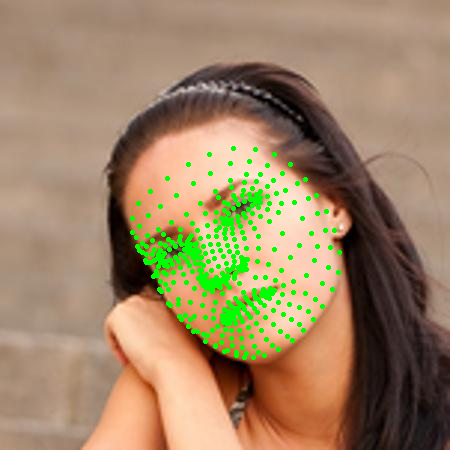

In [57]:
image_name = random.choice(file_test)
faceModule = mp.solutions.face_mesh
with faceModule.FaceMesh(static_image_mode=True) as face:
  # reading the image
  #imagesArr.index(image_name)
  #matricesArr[imagesArr.index(f)]
  frame = cv2.imread(image_name)
  # processing the image to detect the face and then generating the land marks (468 for each x,y,z).
  results = face.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
  if results.multi_face_landmarks != None:
    for face in results.multi_face_landmarks:
        # 
        for j,landmark in enumerate(face.landmark):
            x = landmark.x
            y = landmark.y
            shape = frame.shape 
            relative_x = int(x * shape[1])
            relative_y = int(y * shape[0])
            cv2.circle(frame, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
            #cv2.putText(frame, str(j), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,0,255), 2)
    cv2_imshow(frame)

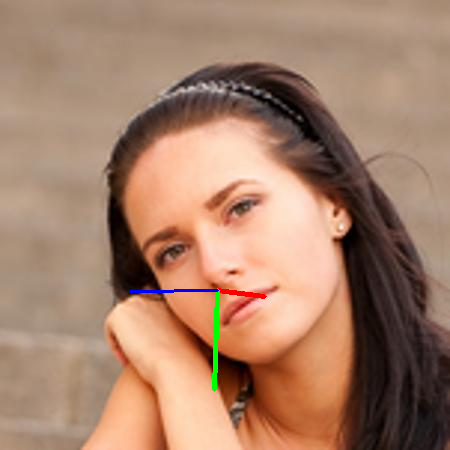

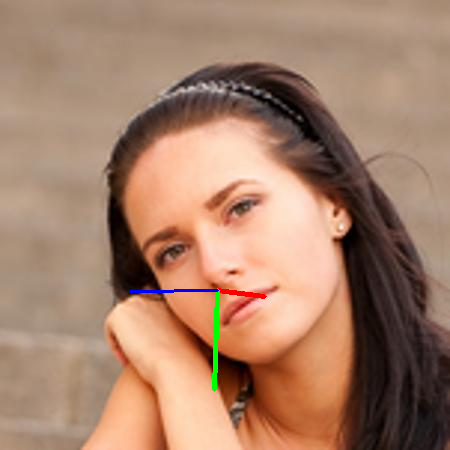

In [58]:
frame = cv2.imread(image_name)
# reading the true labels and drawing the axis on the image
mat = sio.loadmat(matricesArr[imagesArr.index(image_name)])
pitch_true = mat["Pose_Para"][0][0]
yaw_true = mat["Pose_Para"][0][1]
roll_true = mat["Pose_Para"][0][2]
cv2.destroyAllWindows()
cv2_imshow(draw_axis(frame,pitch_true,yaw_true,roll_true,X[99],Y[99]))# reading the image
frame = cv2.imread(image_name)
# reading the true labels and drawing the axis on the image
mat = sio.loadmat(matricesArr[imagesArr.index(image_name)])
pitch_true = mat["Pose_Para"][0][0]
yaw_true = mat["Pose_Para"][0][1]
roll_true = mat["Pose_Para"][0][2]
cv2.destroyAllWindows()
cv2_imshow(draw_axis(frame,pitch_true,yaw_true,roll_true,X[99],Y[99]))
     

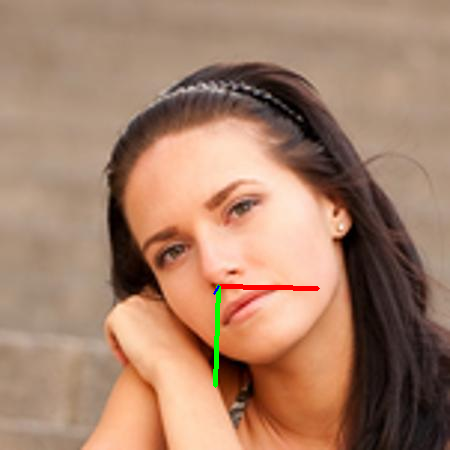

In [59]:
faceModule = mp.solutions.face_mesh
with faceModule.FaceMesh(static_image_mode=True) as face:
  # reading the image
  frame = cv2.imread(image_name)
  # processing the image to detect the face and then generating the land marks (468 for each x,y,z).
  results = face.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
  if results.multi_face_landmarks != None:
    for face in results.multi_face_landmarks:
        # initializing two lists to store x and y points
        X,Y = [],[]
        
        for j,landmark in enumerate(face.landmark):
            x = landmark.x
            y = landmark.y
            # getting the points back to its actual values
            shape = frame.shape 
            
            # appending the points to the X and Y lists
            X.append(int(x * shape[1]))
            Y.append(int(y * shape[0]))

        # converting the x and y points to numpy array
        X = np.array(X)
        Y = np.array(Y)

        # centering the points of x and y values arround the point no. 99
        x_center = X - X[99]
        y_center = Y - Y[99]
        # computing the distance between the point 171 and 10
        d = np.linalg.norm(np.array((X[171],Y[171])) - np.array((X[10],Y[10])))
        # normalizing the points
        X_norm = x_center/d
        Y_norm = y_center/d
        # X_norm = X_norm
        # Y_norm = Y_norm
        # concatinating the x and y points to predict the labels (pitch,yaw,roll)
        points = np.hstack([X_norm,Y_norm]).reshape(1,-1)
        # predicting the 3 angels to draw the axis on the image
        pred_pitch = m_gs_xgb_pitch_be.predict(points)
        pred_yaw = m_gs_xgb_yaw_be.predict(points)
        pred_roll = m_gs_xgb_roll_be.predict(points)
        cv2_imshow(draw_axis(frame,pred_pitch,pred_yaw,pred_roll,X[99],Y[99]))
     

In [92]:
image_name

'AFLW2000/image00846.jpg'

In [60]:
svr_param = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
             'C':[0.01,0.1,1,10,100]}
m_svr_pitch=SVR() 
m_gs_svr_pitch = GridSearchCV(m_svr_pitch,svr_param)
m_gs_svr_pitch.fit(X_train,y_train_yaw)
m_gs_svr_pitch_be = m_gs_svr_pitch.best_estimator_
y_svr_train_pitch = m_gs_svr_pitch_be.predict(X_train)
y_svr_pred_pitch = m_gs_svr_pitch_be.predict(X_val)
print(f"SVR Best Estimator of Pitch angle : {m_gs_svr_pitch_be}")
print(f"SVR Train Error of Pitch angle : {mean_absolute_error(y_svr_train_pitch,y_train_pitch)}")
print(f"SVR Train Validation of Pitch angle : {mean_absolute_error(y_svr_pred_pitch,y_val_pitch)}")
     

SVR Best Estimator of Pitch angle : SVR(C=0.01, kernel='linear')
SVR Train Error of Pitch angle : 0.30719000259649476
SVR Train Validation of Pitch angle : 0.26906446038151277


In [61]:
svr_param = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
             'C':[0.01,0.1,1,10,100]}
m_svr_yaw=SVR() 
m_gs_svr_yaw = GridSearchCV(m_svr_yaw,svr_param)
m_gs_svr_yaw.fit(X_train,y_train_yaw)
m_gs_svr_yaw_be = m_gs_svr_yaw.best_estimator_
y_svr_train_yaw = m_gs_svr_yaw_be.predict(X_train)
y_svr_pred_yaw = m_gs_svr_yaw_be.predict(X_val)
print(f"SVR Best Estimator of yaw angle : {m_gs_svr_yaw_be}")
print(f"SVR Train Error of yaw angle : {mean_absolute_error(y_svr_train_yaw,y_train_yaw)}")
print(f"SVR Train Validation of yaw angle : {mean_absolute_error(y_svr_pred_yaw,y_val_yaw)}")
 

SVR Best Estimator of yaw angle : SVR(C=0.01, kernel='linear')
SVR Train Error of yaw angle : 0.48395630220340513
SVR Train Validation of yaw angle : 0.4520765590555097


In [62]:
svr_param = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
             'C':[0.01,0.1,1,10,100]}
m_svr_roll=SVR() 
m_gs_svr_roll = GridSearchCV(m_svr_roll,svr_param)
m_gs_svr_roll.fit(X_train,y_train_roll)
m_gs_svr_roll_be = m_gs_svr_roll.best_estimator_
y_svr_train_roll = m_gs_svr_roll_be.predict(X_train)
y_svr_pred_roll = m_gs_svr_roll_be.predict(X_val)
print(f"SVR Best Estimator of roll angle : {m_gs_svr_roll_be}")
print(f"SVR Train Error of roll angle : {mean_absolute_error(y_svr_train_roll,y_train_roll)}")
print(f"SVR Train Validation of roll angle : {mean_absolute_error(y_svr_pred_roll,y_val_roll)}")
 

SVR Best Estimator of roll angle : SVR(C=0.1, kernel='poly')
SVR Train Error of roll angle : 0.2917710528821213
SVR Train Validation of roll angle : 0.25372843097598863


In [68]:
image_name='AFLW2000/image00846.jpg'

In [64]:
print(random.choice(file_test))

AFLW2000/image02795.jpg


In [65]:
#image_name = random.choice(file_test)

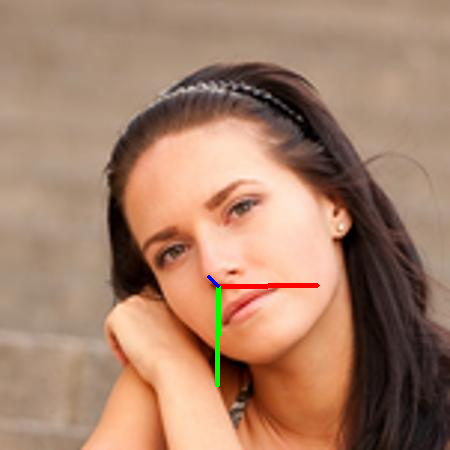

In [69]:
faceModule = mp.solutions.face_mesh
with faceModule.FaceMesh(static_image_mode=True) as face:
  # reading the image
  frame = cv2.imread(image_name)
  # processing the image to detect the face and then generating the land marks (468 for each x,y,z).
  results = face.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
  if results.multi_face_landmarks != None:
    for face in results.multi_face_landmarks:
        # initializing two lists to store x and y points
        X,Y = [],[]
        
        for j,landmark in enumerate(face.landmark):
            x = landmark.x
            y = landmark.y
            # getting the points back to its actual values
            shape = frame.shape 
            
            # appending the points to the X and Y lists
            X.append(int(x * shape[1]))
            Y.append(int(y * shape[0]))

        # converting the x and y points to numpy array
        X = np.array(X)
        Y = np.array(Y)

        # centering the points of x and y values arround the point no. 99
        x_center = X - X[99]
        y_center = Y - Y[99]
        # computing the distance between the point 171 and 10
        d = np.linalg.norm(np.array((X[171],Y[171])) - np.array((X[10],Y[10])))
        # normalizing the points
        X_norm = x_center/d
        Y_norm = y_center/d
        # X_norm = X_norm
        # Y_norm = Y_norm
        # concatinating the x and y points to predict the labels (pitch,yaw,roll)
        points = np.hstack([X_norm,Y_norm]).reshape(1,-1)
        # predicting the 3 angels to draw the axis on the image
        pred_pitch = m_gs_svr_pitch_be.predict(points)
        pred_yaw = m_gs_svr_yaw_be.predict(points)
        pred_roll = m_gs_svr_roll_be.predict(points)
        cv2_imshow(draw_axis(frame,pred_pitch,pred_yaw,pred_roll,X[99],Y[99]))
     

In [71]:
def Create_TestVideo(pitch_model,yaw_model,roll_model,path):
  cap = cv2.VideoCapture(path)
  width= int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  height= int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

  # Check if camera opened successfully
  if (cap.isOpened()== False): 
      print("Error opening video file")
  #a list to store the frames of the video  
  video_array = []
  # Read until video is completed
  while(cap.isOpened()):   
    # Capture frame-by-frame
      ret, frame = cap.read()
      if ret == True:
        # loading image 
        with faceModule.FaceMesh(static_image_mode=True) as faces:
          # processing the face to extract the landmark points (468 point) for each x,y,z
          results = faces.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
          if results.multi_face_landmarks != None: 
            # looping over the faces in the image
            for face in results.multi_face_landmarks:
                # initializing two lists to store the points for every face.
                x_array = []
                y_array = []
                # looping over the 468 points of x and y
                for landmark in face.landmark:
                    x = landmark.x
                    y = landmark.y
                    # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
                    shape = frame.shape 
                    relative_x = int(x * shape[1])
                    relative_y = int(y * shape[0])
                    #Xs of face
                    x_array.append(relative_x)
                    #Ys of face
                    y_array.append(relative_y)

                # converting the x anx y to numpy arrays
                x_array = np.array(x_array)
                y_array = np.array(y_array)

                # centering the points arround the 99th point 
                x_center = x_array - x_array[99]
                y_center = y_array - y_array[99]

                # computing the distance
                distance = np.linalg.norm(np.array((x_array[171],y_array[171])) - np.array((x_array[10],y_array[10])),axis = 0)
                x_norm = x_center / distance
                y_norm = y_center / distance

                # concatinating the x and y points to predict the labels (pitch,yaw,roll)
                features = np.hstack([x_norm,y_norm]).reshape(1,-1)

                # predicting the 3 angels to draw the axis on the image
                pred_pitch = pitch_model.predict(features)
                pred_yaw = yaw_model.predict(features)
                pred_roll = roll_model.predict(features)
                draw_axis(frame,pred_pitch,pred_yaw,pred_roll,x_array[99],y_array[99])
                # appending the result frames to the video_array list
                video_array.append(frame)
      else:
        break
  cap.release()  
  # Closes all the frames
  cv2.destroyAllWindows()
  print("Number of Detected Frames = ",len(video_array))
  # converting the frames to video
  out = cv2.VideoWriter('out.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 20, (width,height))
  for i in range(len(video_array)):
    out.write(video_array[i])
  out.release()
     

In [88]:
path='/content/WIN_20230221_18_56_54_Pro.mp4'
Create_TestVideo(m_gs_svr_pitch_be,m_gs_svr_yaw_be,m_gs_svr_roll_be,path)

Number of Detected Frames =  248


In [89]:
from google.colab import files
files.download('/content/out.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [98]:
path='/content/videoplayback.mp4'
Create_TestVideo(m_gs_svr_pitch_be,m_gs_svr_yaw_be,m_gs_svr_roll_be,path)

Number of Detected Frames =  302


In [100]:
#path='/content/videoplayback.mp4'
Create_TestVideo(m_gs_xgb_pitch_be,m_gs_xgb_yaw_be,m_gs_xgb_roll_be,path)

Number of Detected Frames =  302


In [101]:
from google.colab import files
files.download('/content/out.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>